In [1]:
import os
import glob
import rasterio as rio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.stats

# 1. Stack interpolated disease intensity rasters with DORA anomaly rasters

In [2]:
# Get list of interpolated dis. intensity rasters for 2020

dis_ras = glob.glob('../data/images/2020/PScope/dis_band_*/*.tif')
dis_ras

['../data/images/2020/PScope/dis_band_2020/20200801_151354_03_2212_3B_AnalyticMS_SR_8b_harmonized_clip_clipped.tif_disease.tif',
 '../data/images/2020/PScope/dis_band_2020/20200713_151457_44_2278_3B_AnalyticMS_SR_8b_harmonized_clip_clipped.tif_disease.tif',
 '../data/images/2020/PScope/dis_band_2020/20200616_151605_21_2304_3B_AnalyticMS_SR_8b_harmonized_clip_clipped.tif_disease.tif']

In [3]:
# Get list of anomaly rasters 2020

anom_ras = glob.glob('/Users/kathleenkanaley/Desktop/dora/dora/sample_data/grapes/results/raster_patches_test/PS_2020/*/lrx-inner_window=2-outer_window=5-bands=8/scores_raster_lrx.tif')
anom_ras

['/Users/kathleenkanaley/Desktop/dora/dora/sample_data/grapes/results/raster_patches_test/PS_2020/20200616/lrx-inner_window=2-outer_window=5-bands=8/scores_raster_lrx.tif',
 '/Users/kathleenkanaley/Desktop/dora/dora/sample_data/grapes/results/raster_patches_test/PS_2020/20200713/lrx-inner_window=2-outer_window=5-bands=8/scores_raster_lrx.tif',
 '/Users/kathleenkanaley/Desktop/dora/dora/sample_data/grapes/results/raster_patches_test/PS_2020/20200801/lrx-inner_window=2-outer_window=5-bands=8/scores_raster_lrx.tif']

Disease raster CRS: EPSG:32618
Anomaly raster CRS: EPSG:32618


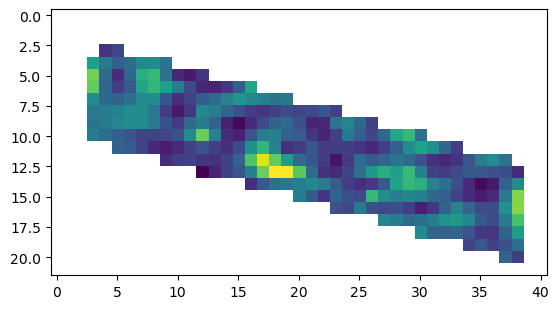

In [4]:
# Test with 2020-06-16 first

june_dis = dis_ras[2]
june_anom = anom_ras[0]

# july_dis = dis_ras[1]
# july_anom = anom_ras[1]

# aug_dis = dis_ras[1]
# aug_anom = anom_ras[2]

# dis_ras = [june_dis, july_dis, aug_dis]
# anom_ras = [june_anom, july_anom, aug_anom]

with rio.open(june_dis) as src:
    june_dis_arr = src.read()
    print('Disease raster CRS:',src.crs)

with rio.open(june_anom) as src:
    june_anom_arr = src.read()
    print('Anomaly raster CRS:',src.crs)

# Plot the total disease severity band
plt.imshow(june_dis_arr[8])

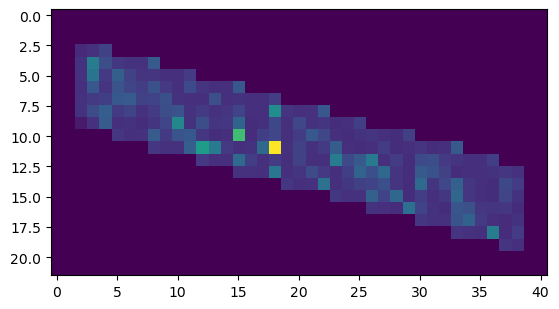

In [5]:
# Plot the anomaly scores
plt.imshow(june_anom_arr[0])

In [6]:
june_anom_arr.shape

(1, 22, 41)

In [7]:
june_dis_arr.shape

(11, 22, 41)

# Band definitions

Band 9 = total disease severity
<br>
Band 10 = DM severity
<br>
Band 11 = DM incidence
<br>

In [8]:
stacked = np.vstack([june_dis_arr, june_anom_arr])

stacked.shape

(12, 22, 41)

# Anomaly scores do not cover full extent of raster

This means that we must restrict correlation analysis to pixels that have both an interpolated disease rating AND an anomaly score.

In [9]:
# Try with the RX rasters (not local rx)

rx_ras = glob.glob('/Users/kathleenkanaley/Desktop/dora/dora/sample_data/grapes/results/raster_patches_test/PS_2020/*/rx/scores_raster_rx.tif')
rx_ras

['/Users/kathleenkanaley/Desktop/dora/dora/sample_data/grapes/results/raster_patches_test/PS_2020/20200616/rx/scores_raster_rx.tif',
 '/Users/kathleenkanaley/Desktop/dora/dora/sample_data/grapes/results/raster_patches_test/PS_2020/20200713/rx/scores_raster_rx.tif',
 '/Users/kathleenkanaley/Desktop/dora/dora/sample_data/grapes/results/raster_patches_test/PS_2020/20200801/rx/scores_raster_rx.tif']

In [10]:
june_dis = dis_ras[2]
june_anom = anom_ras[0]
june_rx = rx_ras[0]


july_dis = dis_ras[1]
july_anom = anom_ras[1]
july_rx = rx_ras[1]

aug_dis = dis_ras[0]
aug_anom = anom_ras[2]
aug_rx = rx_ras[2]

dis_ras = [june_dis, july_dis, aug_dis]
anom_ras = [june_anom, july_anom, aug_anom]
rx_ras = [june_rx, july_rx, aug_rx]

In [11]:
len(dis_ras)

3

In [12]:
np.arange(len(dis_ras))

array([0, 1, 2])

In [13]:
stacked_arrays = []

for i in np.arange(len(dis_ras)):
    with rio.open(dis_ras[i]) as src1:
        dis_arr = src1.read()
    with rio.open(anom_ras[i]) as src2:
        anom_arr = src2.read()
    with rio.open(rx_ras[i]) as src3:
        rx_arr = src3.read()
    
    stacked_arr = np.vstack([dis_arr, anom_arr, rx_arr])
    
    stacked_arrays.append(stacked_arr)
len(stacked_arrays)

3

In [14]:
stacked_arrays[2].shape

(13, 22, 41)

In [26]:
dataframes = []
for arr in stacked_arrays:
    total_sev = arr[8].flatten()
    dm_sev = arr[9].flatten()
    dm_inc = arr[10].flatten()
    lrx = arr[11].flatten()
    rx = arr[12].flatten()
    df = pd.DataFrame(data={'total_dis_sev':total_sev, 
                            'dm_sev':dm_sev,
                            'dm_inc':dm_inc,
                            'lrx_score':lrx,
                            'rx_score': rx})
    df_nonan = df[df['total_dis_sev']>=0]
    dataframes.append(df_nonan)


In [27]:
dataframes[0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 258 entries, 127 to 858
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   total_dis_sev  258 non-null    float64
 1   dm_sev         258 non-null    float64
 2   dm_inc         0 non-null      float64
 3   lrx_score      258 non-null    float64
 4   rx_score       258 non-null    float64
dtypes: float64(5)
memory usage: 12.1 KB


In [28]:
dataframes[1].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 255 entries, 126 to 816
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   total_dis_sev  255 non-null    float64
 1   dm_sev         255 non-null    float64
 2   dm_inc         0 non-null      float64
 3   lrx_score      255 non-null    float64
 4   rx_score       255 non-null    float64
dtypes: float64(5)
memory usage: 12.0 KB


In [29]:
dataframes[2].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269 entries, 127 to 817
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   total_dis_sev  269 non-null    float64
 1   dm_sev         269 non-null    float64
 2   dm_inc         269 non-null    float64
 3   lrx_score      269 non-null    float64
 4   rx_score       269 non-null    float64
dtypes: float64(5)
memory usage: 12.6 KB


In [35]:
for df in dataframes:
    res = scipy.stats.spearmanr(np.sqrt(df['total_dis_sev']), np.sqrt(df['lrx_score']))
    print('Spearman r:', res[0], '\np-value:', res[1])

Spearman r: 0.0639263319273266 
p-value: 0.30636952835486736
Spearman r: -0.11082601347355842 
p-value: 0.07731196741721263
Spearman r: -0.1119090819754106 
p-value: 0.06685331557750286


In [36]:
for df in dataframes:
    res = scipy.stats.spearmanr(df['dm_sev'], df['lrx_score'])
    print('Spearman r:', res[0], '\np-value:', res[1])

Spearman r: -0.10995194746914082 
p-value: 0.07792365653755406
Spearman r: -0.17224529346452458 
p-value: 0.005821604307402325
Spearman r: -0.09745684314459678 
p-value: 0.11076457024464013


In [37]:
for df in dataframes:
    res = scipy.stats.spearmanr(df['dm_sev'], df['rx_score'])
    print('Spearman r:', res[0], '\np-value:', res[1])

Spearman r: 0.04569163986481138 
p-value: 0.46494139543131263
Spearman r: 0.04984150648448355 
p-value: 0.42807653970535786
Spearman r: 0.04129291584210299 
p-value: 0.5000646451574615


In [38]:
for df in dataframes:
    res = scipy.stats.spearmanr(df['total_dis_sev'], df['rx_score'])
    print('Spearman r:', res[0], '\np-value:', res[1])

Spearman r: -0.20429818442646963 
p-value: 0.0009652681057892253
Spearman r: 0.05069187123668365 
p-value: 0.42022809502857494
Spearman r: 0.026405148976308048 
p-value: 0.6663701574666576


In [39]:
res = scipy.stats.spearmanr(dataframes[2]['dm_inc'], dataframes[2]['rx_score'])
print('Spearman r:', res[0], '\np-value:', res[1])

Spearman r: 0.11726990820371498 
p-value: 0.054725888138106644


In [40]:
for df in dataframes:
    print(df.corr())

               total_dis_sev    dm_sev  dm_inc  lrx_score  rx_score
total_dis_sev       1.000000  0.111405     NaN   0.099228 -0.165065
dm_sev              0.111405  1.000000     NaN  -0.064198  0.028384
dm_inc                   NaN       NaN     NaN        NaN       NaN
lrx_score           0.099228 -0.064198     NaN   1.000000 -0.150976
rx_score           -0.165065  0.028384     NaN  -0.150976  1.000000
               total_dis_sev    dm_sev  dm_inc  lrx_score  rx_score
total_dis_sev       1.000000  0.256359     NaN  -0.119063  0.085597
dm_sev              0.256359  1.000000     NaN  -0.057386  0.216716
dm_inc                   NaN       NaN     NaN        NaN       NaN
lrx_score          -0.119063 -0.057386     NaN   1.000000 -0.062187
rx_score            0.085597  0.216716     NaN  -0.062187  1.000000
               total_dis_sev    dm_sev    dm_inc  lrx_score  rx_score
total_dis_sev       1.000000  0.810633  0.511674  -0.107064  0.068061
dm_sev              0.810633  1.000000  0.71

<AxesSubplot: >

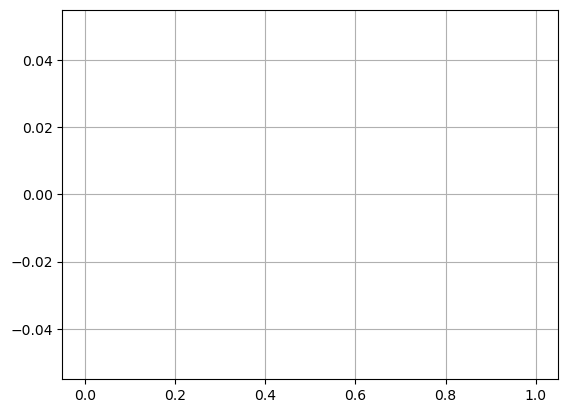

In [47]:
%matplotlib inline

dataframes[0]['dm_inc'].hist(bins=8)